Testing how important including the global total emissions in the inputs is. This version is the same as the GP0 model, but without global total emissions as an input, only using regional inputs.

Results are much poorer performance on RAMIP

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import cartopy.crs as ccrs
import gpflow
import tensorflow as tf
import glob
from utils_GP import *

In [3]:
#set up

#data files:
in_files = glob.glob('../training_data_Ann/inputs*.nc')
out_files = glob.glob('../training_data_Ann/outputs*.nc')

#checkpointing folder (should correspond to GP notebook number):
log_dir = "logs_1"

#option to load trained model or optimize new one:
opt = True #if True, train new model, else load existing model from latest checkpoint in log_dir

In [7]:
#modify pre-processing (prep_inputs) which is normally in utils_GP.py
#not including global total emissions as a input

pert_regions_noGB = dict([
    ('eu', [165, 37, 210, 73]),
    ('ru', [210, 45, 380, 80]),
    ('ea', [270, -10, 330, 45]),
    ('wa', [240, 0, 270, 45]),
    ('au', [285, -45, 340, -10]),
    ('na', [10, 15, 125, 75]),
    ('sa', [95, -60, 150, 15]),
    ('af', [155, -40, 240, 37])
])

def prep_inputs_noGB(in_files):
    #loop over input files and create a dataframe of emissions for each pert region for each year and experiment.
    input_df = pd.DataFrame()

    data = xr.open_mfdataset(in_files, combine='nested', concat_dim='year', preprocess=add_year)

    inputs = create_predictor_regions(pert_regions_noGB, data)
    inputs0 = inputs.fillna(0)
    input_df = pd.concat([input_df, inputs0], axis=0)

    return input_df

In [9]:
#create train/test split:
train_in = in_files[0:21]+in_files[22:24]
test_in = in_files[21]

train_out = out_files[0:21]+out_files[22:24]
test_out = out_files[21]

#prepare training data:
train_input_df = prep_inputs_noGB(train_in)
train_output_df = prep_outputs(train_out)

#prepare test data:
test_input_df = prep_inputs_noGB([test_in])
test_output = xr.open_dataset(test_out)['tas_diff']

#normalize data:
train_output_norm = ((train_output_df-train_output_df.mean())/train_output_df.std())
train_input_norm = ((train_input_df-train_input_df.mean())/train_input_df.std())

#check array sizes are compatible:
print(np.shape(train_input_norm))
print(np.shape(train_output_norm))
print(np.shape(test_input_df))

../training_data_Ann\outputs_0xEA_SO2_Ann.nc
../training_data_Ann\outputs_0xEU_SO2_Ann.nc
../training_data_Ann\outputs_0xNA_SO2_Ann.nc
../training_data_Ann\outputs_0xSA_SO2_Ann.nc
../training_data_Ann\outputs_10xEU_BC_Ann.nc
../training_data_Ann\outputs_10xNA_BC_Ann.nc
../training_data_Ann\outputs_10xSA_BC_Ann.nc
../training_data_Ann\outputs_10xSA_SO2_Ann.nc
../training_data_Ann\outputs_5xEA_BC_Ann.nc
../training_data_Ann\outputs_5xEA_SO2_Ann.nc
../training_data_Ann\outputs_5xNA_SO2_Ann.nc
../training_data_Ann\outputs_7xEU_SO2_Ann.nc
../training_data_Ann\outputs_global_anthro_Ann.nc
../training_data_Ann\outputs_global_BC_Ann.nc
../training_data_Ann\outputs_global_OC_Ann.nc
../training_data_Ann\outputs_global_SO2_Ann.nc
../training_data_Ann\outputs_hist-aer.nc
../training_data_Ann\outputs_ramip_af.nc
../training_data_Ann\outputs_ramip_ea.nc
../training_data_Ann\outputs_ramip_nae.nc
../training_data_Ann\outputs_ramip_sa.nc
../training_data_Ann\outputs_ssp245-aer.nc
../training_data_Ann\o

In [10]:
#set up basic GP model:

# Make kernel
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[0, 3, 6, 9, 12, 15, 18, 21])
kernel_BC = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[1, 4, 7, 10, 13, 16, 19, 22])
kernel_OC = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[2, 5, 8, 11, 14, 17, 20, 23])

kernel = kernel_BC + kernel_SO2 + kernel_OC #+ gpflow.kernels.White()

np.random.seed(5)

#define model
model = gpflow.models.GPR(data=(train_input_norm.astype(np.float64), 
                                train_output_norm.astype(np.float64)),
                        kernel=kernel)

#setup checkpointing:
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint, log_dir, max_to_keep=5)
if opt:
        manager.save()

checkpoint_task = gpflow.monitor.ExecuteCallback(manager.save)
tast_group = gpflow.monitor.MonitorTaskGroup(checkpoint_task, period=5)
monitor = gpflow.monitor.Monitor(tast_group)

In [11]:
#train model (if opt=True), otherwise load from latest checkpoint.

if opt:
    # Define optimizer
    opt = gpflow.optimizers.Scipy()

    # Train model
    opt.minimize(model.training_loss,
                variables=model.trainable_variables,
                options=dict(disp=True, maxiter=1000),
                step_callback=monitor)
    
else:
    #load from checkpoint:
    checkpoint.restore(manager.latest_checkpoint)

In [12]:
#print model parameters:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.16343149450008695
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[33.99712174, 15.76083826, 66.73678658..."
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.8736820409926956
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[105.7126474, 9.02395247, 98.47585273..."
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.14742385603794086
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[1.00554389, 19.79322366, 1.29523044..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.8259226218496125


In [13]:
#test model:

test_input_norm = ((test_input_df-train_input_df.mean())/train_input_df.std())

standard_posterior_mean, standard_posterior_var = model.predict_y(test_input_norm.values)

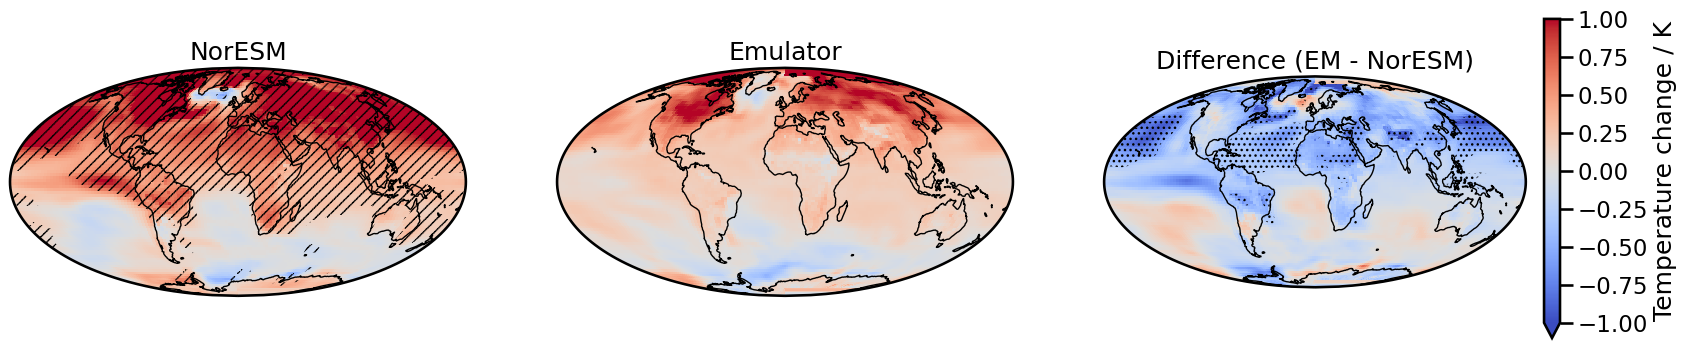

In [14]:
#plot test:

#un-normalize posterior:
posterior_mean = (standard_posterior_mean * train_output_df.std()) + train_output_df.mean()
train_std = tf.expand_dims(train_output_df.std(),axis=0)
posterior_std = np.sqrt(standard_posterior_var) * train_std

posterior_tas = np.reshape(posterior_mean, np.shape(test_output))#[years, 96, 144])
posterior_tas_std = np.reshape(posterior_std, np.shape(test_output))#[years, 96, 144])
posterior_tas_data = xr.DataArray(posterior_tas, dims=test_output.dims, coords=test_output.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=test_output.dims, coords=test_output.coords)

#get periods for comparison plot:
output_std = test_output.sel(year=slice(2050,2059)).std('year')
post_std = np.sqrt(np.power(posterior_tas_std_data.sel(year=slice(2050,2059)),2).mean('year'))

output_mean = test_output.sel(year=slice(2050,2059)).mean('year')
post_mean = posterior_tas_data.sel(year=slice(2050, 2059)).mean('year')

#ttest where difference between prediction and NorESM is significant:
from scipy.stats import ttest_ind_from_stats as ttest
z_em,p_em = ttest(output_mean, output_std, 10, post_mean, post_std, 10, equal_var=False, alternative='two-sided')

divnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
diffnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
proj = ccrs.Mollweide()

t1_pgrid = np.load('C:/Users/made2928/OneDrive/Documents/MISU/NorESMem/ramip_t1_NorESMpgrid',allow_pickle=True)
p1mask = np.ma.masked_greater(t1_pgrid, 0.05)

with sns.plotting_context("talk"):
    ## Truth
    fig = plt.figure(figsize=(20, 6))
 
    plt.subplot(131, projection=proj)
    output_mean.plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm, add_colorbar=False)
    plt.pcolor(test_output.lon, test_output.lat, p1mask[4,:,:], hatch='///', alpha=0., transform=ccrs.PlateCarree())
                      
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='NorESM')


    # Emulator
    plt.subplot(132, projection=proj)
    post_mean.plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=divnorm, add_colorbar=False)
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Emulator')

    # Difference
    difference = post_mean - output_mean
    plt.subplot(133, projection=proj)
    difference.plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=diffnorm,
                    cbar_kwargs={"label":"Temperature change / K",'pad':0.04,'fraction':0.035})
    cs = plt.contourf(difference.lon, difference.lat, p_em, colors='none', levels=[0,0.05],
                    hatches=['...'], alpha=0., transform=ccrs.PlateCarree())


    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference (EM - NorESM)')

Text(0, 0.5, 'Global mean temperature change / K')

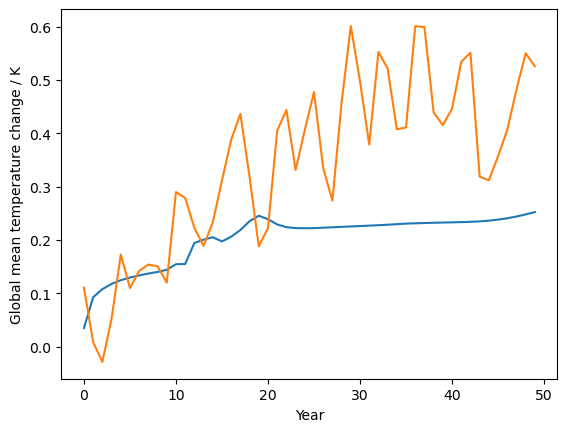

In [15]:
#plot global mean tas comparison:
plt.plot(lat_weighted_mean(posterior_tas_data))
plt.plot(lat_weighted_mean(test_output))
plt.xlabel('Year')
plt.ylabel('Global mean temperature change / K')